# Misbehavior Detection in Vehicular Networks with Federated Learning

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import locale
import flwr as fl
import numpy as np
import pandas as pd
from abc import ABC
from metrics import *
import seaborn as sns
import tensorflow as tf
from itertools import cycle
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from typing import Optional, Tuple, Dict, Any
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.set_visible_devices(physical_devices[1:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  assert len(logical_devices) == len(physical_devices) - 1
except:
  pass

tf.get_logger().setLevel('ERROR')
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
locale._override_localeconv = {'thousands_sep': '.'}

from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

## Support Functions

In [8]:
def load_veremi(csv_file: str, feature: str, label: str, delimiter=','):
    # Import VeReMi Dataset
    data = pd.read_csv(csv_file, delimiter=delimiter)

    data_normal = data.loc[data['attackerType'] == 0]
    data_atk = data.loc[data['attackerType'] != 0]
    atk_size = int(data_atk.shape[0])
    data = pd.concat([data_normal.sample(atk_size), data_atk])
    data = shuffle(data)

    dataset = data
    target = data[data.columns[-1:]]
    data = data[data.columns[0:-1]]

    # normalize data
    data = (data - data.mean()) / data.std()

    # label binarize one-hot style
    lb = preprocessing.LabelBinarizer()
    lb.fit(target)
    if label == 'multiclass':
        target = lb.transform(target)
    else:
        target = lb.transform(target)
        target = MultiLabelBinarizer().fit_transform(target)

    # Create training and test data
    train_data, test_data, train_labels, test_labels = train_test_split(
        data,
        target,
        train_size=Config.data_train_size,
        test_size=Config.data_test_size,
        # random_state=42
    )

    return train_data, test_data, train_labels, test_labels, lb, dataset

## Config Class

In [9]:
class Config:
    csv = "../Downloads/downloads/VeReMi_v2.csv"
    model_type = "mlp"
    label = "multiclass"
    feature = "feat4"
    batch_size = 128
    epochs = 50
    rounds = 80
    learning_rate = 3e-4 #1e-3
    min_available_clients = 2
    fraction_fit = 0.1
    early_stop_patience = 3
    early_stop_monitor = "loss"
    early_stop_min_delta = 1e-4
    early_stop_restore_best_weights = True
    data_train_size = 0.8
    data_test_size = 0.2
    output_path = f"results/{feature}/{label}/"
    performance_file = "performance.csv"
    weights_file = "model_weights.npz"

## Metrics

In [10]:
def recall(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def f1(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

## VeReMi Base Class

In [11]:
class VeremiBase(ABC):
    def __init__(self, data_file: str, model_type: str, label: str, feature: str, activation: str = "softmax"):
        """ The Veremi Client Constructor
            :param model_type: Keras Model Type ('mlp' or 'lstm'
            :param label: Model label type ('binary', 'multiclass', 'atk_1', 'atk_2', 'atk_4', 'atk_8', 'atk_16')
            :param feature: Feature to evaluate ('feat1', 'feat2', 'feat3')
        """
        self.lb = None
        self.dataset = None
        self.train_data = None
        self.test_data = None
        self.train_labels = None
        self.test_labels = None
        self.model = None
        self.data_file = data_file
        self.label = label
        self.feature = feature
        self.model_type = model_type
        self.activation = activation

        self.load_veremi()
        self.create_model()

    def create_model(self):
        layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, output = \
            None, None, None, None, None, None, None, None, None, None
        if self.model_type == 'mlp':
            layer1 = keras.layers.Input(shape=(self.train_data.shape[1],))
            layer2 = keras.layers.Dense(256, activation="relu")(layer1)
            layer3 = keras.layers.Dense(256, activation="relu")(layer2)
            layer4 = keras.layers.Dropout(0.5)(layer3)
            output = keras.layers.Dense(self.train_labels.shape[1], activation=self.activation)(layer4)
        else:
            pass

        # ML Model
        name = self.label + "-" + self.model_type + "-" + self.feature
        self.model = keras.Model(inputs=layer1, outputs=output, name=name)
        self.model.compile(
            loss=keras.losses.CategoricalCrossentropy(),
            optimizer=keras.optimizers.Adam(learning_rate=Config.learning_rate),
            metrics=[f1]
        )
        self.model.summary()

    def load_veremi(self):
        print("Loading dataset in " + self.__class__.__name__ + "...")
        self.train_data, self.test_data, self.train_labels, self.test_labels, self.lb, self.dataset = load_veremi(
            self.data_file,
            feature=self.feature,
            label=self.label
        )

## VeReMi Client Class

In [12]:
class VeremiClient(VeremiBase, fl.client.NumPyClient):
    def __init__(self, data_file: str, model_type: str, label: str, feature: str):
        VeremiBase.__init__(self, data_file, model_type, label, feature)
        self.history = None

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config, verbose):
        print("Training...")
        early_stopping = keras.callbacks.EarlyStopping(
            monitor=Config.early_stop_monitor,
            patience=Config.early_stop_patience,
            min_delta=Config.early_stop_min_delta,
            restore_best_weights=Config.early_stop_restore_best_weights
        )
        if parameters is not None:
            self.model.set_weights(parameters)
        self.history = self.model.fit(
            self.train_data,
            self.train_labels,
            batch_size=config["batch_size"],
            epochs=config["epochs"],
            # callbacks=[early_stopping],
            validation_data=(self.test_data, self.test_labels),
            verbose=verbose,
        )
        result = {
            "f1_score:": float(self.history.history['f1'][-1]),
            "f1_val": float(self.history.history['val_f1'][-1]),
        }
        print("Finished!")
        return self.model.get_weights(), len(self.train_data), result

### Create Client

In [13]:
client = VeremiClient(Config.csv, Config.model_type, Config.label, Config.feature)

Loading dataset in VeremiClient...


C:\Users\hicol\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hicol\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\hicol\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\hicol\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

Model: "multiclass-mlp-feat4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,382 (271.02 KB)

 Trainable params: 69,382 (271.02 KB)

 Non-trainable params: 0 (0.00 B)

## VeReMi DataSet

In [14]:
client.dataset

,aoa0,aoa1,RSSI0,RSSI1,distance0,distance1,conformity1,attackerType
873138,-0.664895,-1.776568,2.650224e-09,6.224842e-08,179.826835,32.722701,95.131999,0
587735,3.127317,-3.070888,7.461697e-08,1.075816e-08,35.425168,266.884310,151.811040,0
1109392,-3.079551,2.716355,1.548660e-09,1.695959e-09,497.212308,302.807862,251.228223,8
1674575,-3.116403,-2.943554,4.592471e-07,4.702216e-08,79.961781,172.996955,22.748868,0
1008508,0.821538,-3.045760,2.809152e-07,2.212318e-07,6704.526516,4186.565835,10209.885151,4
...,...,...,...,...,...,...,...,...
1332793,-0.632251,-0.822416,5.209583e-09,2.681469e-08,211.493232,77.811682,1.988429,0
785199,-1.541811,-0.935131,9.791369e-09,1.244653e-06,5640.561563,4065.255943,3361.521586,4
1616686,0.265324,0.187838,1.586992e-08,2.643953e-09,824.577530,824.114715,58.856287,16
958314,2.141054,0.575829,6.376109e-09,3.067462e-09,6486.806670,2528.233301,6572.279625,4


In [15]:
client.train_data.describe()

,aoa0,aoa1,RSSI0,RSSI1,distance0,distance1,conformity1
count,541771.000000,541771.000000,541771.000000,541771.000000,541771.000000,541771.000000,541771.000000
mean,-0.000723,-0.000717,-0.000832,0.000545,-0.000033,-0.000389,-0.000120
std,0.999689,0.999788,0.937514,1.018028,0.999514,0.999064,0.999046
min,-1.607605,-1.607884,-0.151104,-0.150040,-0.497771,-0.499408,-0.361704
25%,-0.829575,-0.831717,-0.149857,-0.148797,-0.433626,-0.434373,-0.358988
50%,0.048327,0.048541,-0.146602,-0.145580,-0.332890,-0.333502,-0.322226
75%,0.840322,0.839352,-0.129055,-0.128223,-0.173775,-0.174603,-0.210959
max,1.621965,1.616701,55.728280,252.532658,6.912846,6.800375,7.668008


In [17]:
attack = len(client.dataset[client.dataset.attackerType != 0])
normal = len(client.dataset[client.dataset.attackerType == 0])
total = attack + normal
print('Attackers:\n    Total: {:,d}\n    Attack: {:,d} ({:.2f}% of total)\n'.format(
    total, attack, 100 * attack / total))

Attackers:
    Total: 677,214
    Attack: 338,607 (50.00% of total)



## Fit the MLP Model

### Load Model Params

In [18]:
initial_parameters = None
file = Config.output_path + Config.weights_file
if os.path.exists(file):
    npzfile = np.load(file)
    params = [npzfile[x] for x in npzfile]
    params = fl.common.ndarrays_to_parameters(params)
    initial_parameters = fl.common.parameters_to_ndarrays(params)
    print("Setting model params...")
    client.model.set_weights(initial_parameters)

In [19]:
results = client.fit(
    parameters=None, # initial_parameters,
    config={
        "batch_size": Config.batch_size,
        "epochs": Config.epochs
    },
    verbose=1
)

Training...
Epoch 1/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - f1: 0.6895 - loss: 0.8028 - val_f1: 0.7927 - val_loss: 0.5729
Epoch 2/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - f1: 0.7914 - loss: 0.5772 - val_f1: 0.8085 - val_loss: 0.5285
Epoch 3/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - f1: 0.8066 - loss: 0.5380 - val_f1: 0.8218 - val_loss: 0.4974
Epoch 4/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1: 0.8191 - loss: 0.5115 - val_f1: 0.8279 - val_loss: 0.4802
Epoch 5/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1: 0.8257 - loss: 0.4950 - val_f1: 0.8360 - val_loss: 0.4660
Epoch 6/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1: 0.8304 - loss: 0.4838 - val_f1: 0.8397 - val_loss: 0.4542
Epoch 7/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1: 0.8340 - loss: 0.4738 - val_f1: 0.8422 - val_loss: 0.4495
Epoch 8/50
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1: 0.8373 - loss: 0.4650 - val_f1: 0.8446 - val_loss: 0.4412
Epoch 9/50
4233/4233 ━━━━━━━━━━━━━━━

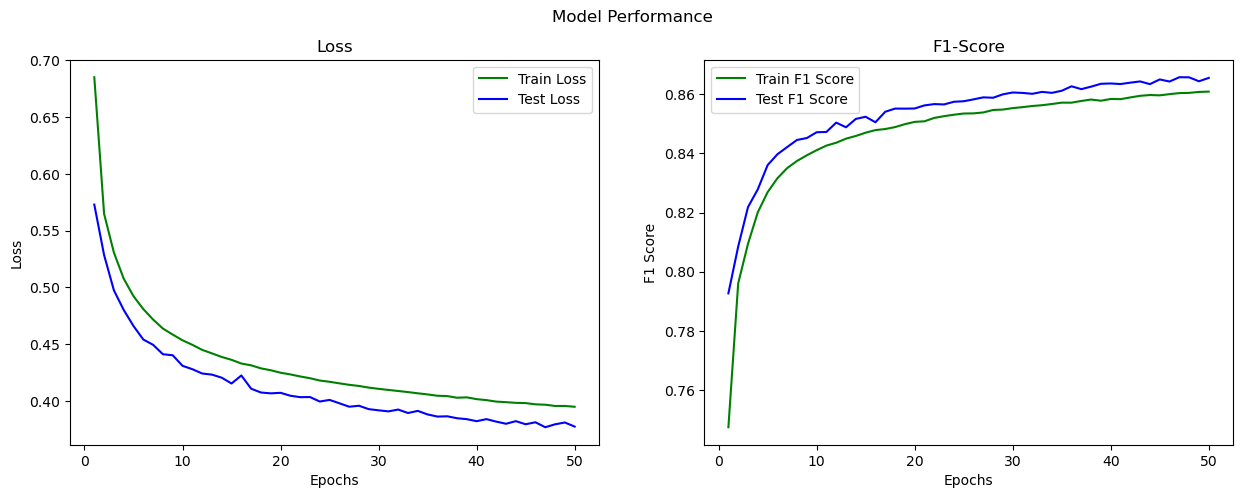

In [20]:
train_f1_score = client.history.history['f1']
test_f1_score = client.history.history['val_f1']
train_loss = client.history.history['loss']
test_loss = client.history.history['val_loss']
epochs = range(1, Config.epochs + 1)
loss, num_examples, metrics = results

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Model Performance')
fig.set_figwidth(15)
fig.set_figheight(5)

ax1.plot(epochs, train_loss, '-g', label="Train Loss")
ax1.plot(epochs, test_loss, '-b', label="Test Loss")
ax1.legend()
ax1.set(xlabel='Epochs', ylabel='Loss')
ax1.set_title('Loss')

ax2.plot(epochs, train_f1_score, '-g', label="Train F1 Score")
ax2.plot(epochs, test_f1_score, '-b', label="Test F1 Score")
ax2.legend()
ax2.set(xlabel='Epochs', ylabel='F1 Score')
ax2.set_title('F1-Score')

plt.show()

In [21]:
def plot_pr_roc_curves(probabilities: Any):
    n_classes = client.test_labels.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    pr_auc = dict()
        
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(client.test_labels[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        precision[i], recall[i], _ = precision_recall_curve(client.test_labels[:, i], probabilities[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    # First aggregate all false positive rates
    all_precision = np.unique(np.concatenate([precision[i] for i in range(n_classes)]))
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    mean_recall = np.zeros_like(all_precision)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_recall += np.interp(all_precision, precision[i], recall[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    mean_recall /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    precision["macro"] = all_precision
    recall["macro"] = mean_recall
    pr_auc["macro"] = auc(recall["macro"], precision["macro"])

    lw = 2
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('PR and ROC Curves - Multiclass')
    fig.set_figwidth(15)
    fig.set_figheight(5)

    colors = cycle(["b", "g", "r", "c", "m", "y"])
    
    # ROC Curve
    ax1.plot(
        fpr["macro"],
        tpr["macro"],
        label="Macro Avg (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
        alpha=0.5,        
    )
    for i, color in zip(range(n_classes), colors):
        label_classes = int(client.lb.classes_[i])
        ax1.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="Class {0} (area = {1:0.2f})".format(label_classes, roc_auc[i]),
            alpha=0.5
        )
    ax1.set_title(f"ROC Curve - {Config.feature} - {Config.label}")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.legend()

    # PR curve
    ax2.plot(
        precision["macro"],
        recall["macro"],
        label="Macro Avg (area = {0:0.2f})".format(pr_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
        alpha=0.5,
    )
    for i, color in zip(range(n_classes), colors):
        label_classes = int(client.lb.classes_[i])
        ax2.plot(
            precision[i],
            recall[i],
            color=color,
            lw=lw,
            label="Class {0} (area = {1:0.2f})".format(label_classes, pr_auc[i]),
            alpha=0.5
        )
    ax2.set_title(f"PR Curve - {Config.feature} - {Config.label}")    
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.legend()
    
    plt.show()

4233/4233 ━━━━━━━━━━━━━━━━━━━━ 4s 978us/step


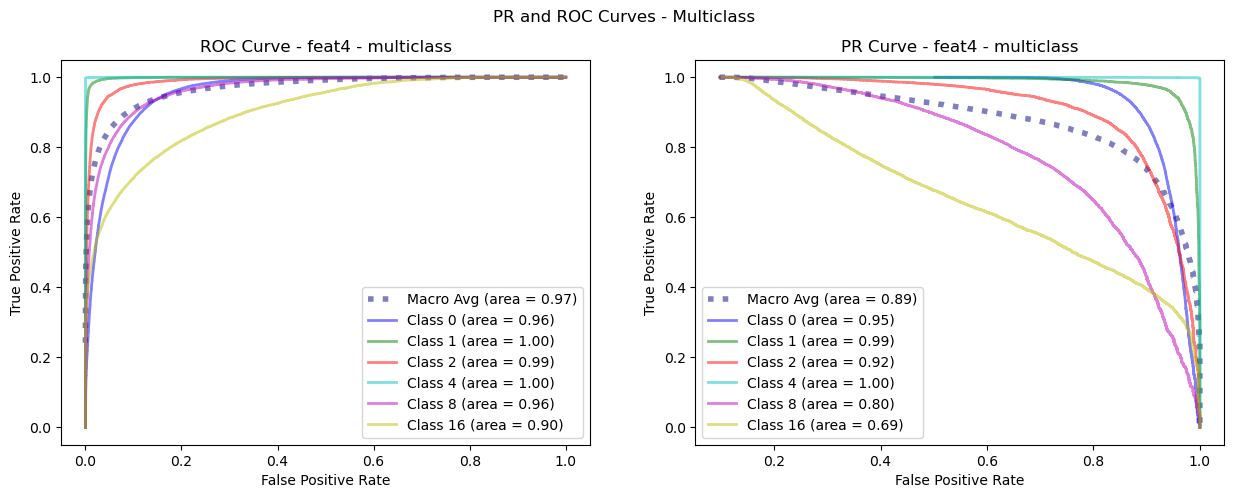

In [22]:
probabilities = client.model.predict(client.test_data)
inverse_target = client.lb.inverse_transform(client.test_labels)
prediction = None

if Config.label == 'multiclass':
    prediction = client.lb.inverse_transform(probabilities)
    # TODO: PLOT MULTICLASS 
    plot_pr_roc_curves(probabilities)
else:
    pos_label = 1 if Config.label == 'binary' else int(Config.label.split("_")[1])
    # Best threshold
    precision, recall, thresholds = precision_recall_curve(
        inverse_target,
        probabilities[:, 1],
        pos_label=pos_label
    )
    # convert to f score
    np.seterr(divide='ignore', invalid='ignore')
    fscore = (2 * precision * recall) / (precision + recall)
    np.nan_to_num(fscore, copy=False)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    print("-" * 70)
    
    prediction = np.where(np.array(probabilities[:, 1]) >= thresholds[ix], pos_label, 0)
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('PR and ROC Curves')
    fig.set_figwidth(15)
    fig.set_figheight(5)

    # PR Curve
    PrecisionRecallDisplay.from_predictions(inverse_target, probabilities[:, 1], pos_label=pos_label, ax=ax1)
    no_skill = len(inverse_target[inverse_target == 1]) / len(inverse_target)
    ax1.plot([0, 1], [no_skill, no_skill], linestyle='--', color="grey", label='No Skill')
    ax1.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
    ax1.set_title(f"PR Curve - {Config.feature} - {Config.label}")
    ax1.legend()

    # ROC curve
    RocCurveDisplay.from_predictions(inverse_target, probabilities[:, 1], pos_label=pos_label, ax=ax2)
    ax2.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
    ax2.set_title(f"ROC Curve - {Config.feature} - {Config.label}")
    
    plt.show()

### Classification Report

In [23]:
classlist = []
for cl in client.lb.classes_:
    classlist.append('class ' + str(int(cl)))

print(classification_report(inverse_target, prediction, target_names=classlist, digits=3, zero_division=0))
print("-" * 70)

              precision    recall  f1-score   support

     class 0      0.852     0.949     0.898     67969
     class 1      0.942     0.960     0.951     13214
     class 2      0.835     0.859     0.847     13349
     class 4      1.000     0.997     0.998     13573
     class 8      0.756     0.698     0.726     13462
    class 16      0.870     0.411     0.558     13876

    accuracy                          0.866    135443
   macro avg      0.876     0.812     0.830    135443
weighted avg      0.866     0.866     0.856    135443

----------------------------------------------------------------------


### Confusion Matrix

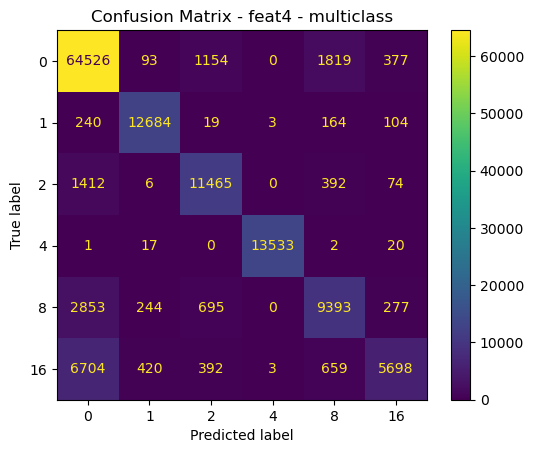

In [24]:
cm = confusion_matrix(inverse_target, prediction, labels=client.lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=client.lb.classes_)
disp.plot()
plt.title(f"Confusion Matrix - {Config.feature} - {Config.label}")
plt.show()

### Performance

In [25]:
name = Config.label + "-" + Config.model_type + "-" + Config.feature
if Config.label == 'multiclass':
    prscore = precision_score(inverse_target, prediction, average='macro', zero_division=0)
    rcscore = recall_score(inverse_target, prediction, average='macro', zero_division=0)
    f1score = f1_score(inverse_target, prediction, average='macro', zero_division=0)
    accscore = accuracy_score(inverse_target, prediction)
else:
    prscore = precision_score(inverse_target, prediction, pos_label=pos_label, zero_division=0)
    rcscore = recall_score(inverse_target, prediction, pos_label=pos_label, zero_division=0)
    f1score = f1_score(inverse_target, prediction, pos_label=pos_label, zero_division=0)
    accscore = accuracy_score(inverse_target, prediction)
data_performance = {name: [prscore, rcscore, f1score, accscore]}
df_performance = pd.DataFrame.from_dict(data_performance, orient='index', columns=["precision", "recall", "f1score", "accuracy"])
df_performance

,precision,recall,f1score,accuracy
multiclass-mlp-feat4,0.875767,0.812256,0.829611,0.86604
